![banner](https://user-images.githubusercontent.com/5395649/46774810-22395980-ccb9-11e8-8f1a-535769d657ec.png)

# Speech Command Recognition Task with Keras 

In this notebook, we will train a simple convolutional neural network (CNN) to recognize utterances of different words. 

In [10]:
import keras 
import tensorflow as tf
import numpy as np
import librosa
import os 
from sklearn.model_selection import train_test_split
import hashlib 
import re
import pandas as pd 
import IPython.display as ipd
from sklearn.metrics import confusion_matrix
import seaborn
from tqdm import tqdm 
import pickle as pkl 

#from preprocess import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

First, let's take a look at the different library versions we will be using in this notebook.

[librosa](https://librosa.github.io/librosa/) is an interesting python library for audio analysis. The paper describing the library can be found [here](http://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf).

In [ ]:
print(tf.__version__, keras.__version__, librosa.__version__, pd.__version__)

# Before we get started... 

* **If you are unfamiliar with signal processing in general, we recommend you review the notebook `1-intro-to-audio-data.ipynb`. To run this notebook, you'll need to download the raw data from Oracle Cloud Infrastructure Object Storage. Execute the shell script `get-data-from-oci.sh` and change the directory where you want the data to be stored on your drive. **


* You don't need the raw data to run this notebook. You will be able to load a pre-processed dataset that is stored in the git repo. This dataset will work for all default parameters provided in this notebook. 

Let us define some variables that will be used throughout the notebook. 

* `data_dir` points to the `wav` folder of the dataset. On the platform, this means `/home/datascience/data/`.
* `MAX_NUM_WAVS_PER_CLASS` is the maximum number of audio clip examples per word class. Leave it as is for now.

## A few words on the dataset 

The dataset we use is the [Speech Commands Dataset](https://arxiv.org/abs/1804.03209). This dataset includes 105k utterances of 35 words. Each word has its corresponding folder containing between 1k and 4k examples. Over 2k speakers were recorded. Each clip lasts 1 second at a sampling rate of 16 kHz. The uncompressed data take about 4Gb on disk. 

The dataset is licensed under the [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/). See the LICENSE file in the dataset folder for full details. Its original location was at
[http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz](

In [11]:
# the root directory of the dataset 
data_dir = '/home/datascience/data/'

MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

# Training, validation and testing data split. An 80-10-10% split is standard. 
training_fraction = 80.0
validation_fraction = 10.0
testing_fraction = 10.0 

# Lets find what words are available for us to classify: 
words_available = [ d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d)) ] 

# This is the list of available utterances one can use in their classifier
print(words_available)

['eight', 'sheila', '_background_noise_', 'nine', 'yes', 'one', 'no', 'left', 'tree', 'bed', 'bird', 'go', 'wow', 'seven', 'marvin', 'dog', 'three', 'two', 'house', 'backward', 'down', 'six', 'five', 'off', 'right', 'cat', 'zero', 'four', 'forward', 'stop', 'up', 'visual', 'learn', 'on', 'happy', 'follow']


For this particular model, I will train a classifier whose purpose will be to 
classify utterances of the words "right", "eight", "cat"

In [12]:
words_selected = ['right','eight','cat']

Below is a function I took directly from the `README` file that came with the dataset. This is a very useful function that ensures testing/validation data does not make its way in the training dataset. We will be using it to assign the sample (training, validation, testing) to which each audio clip belongs. 

In [13]:
# From Warden (2018) : https://arxiv.org/abs/1804.03209

def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.
    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted 
    for example. To keep this stability, a hash of the filename is taken and used 
    to determine which set it should belong to. This determination only depends on 
    the name and the set proportions, so it won't change as other files are added.
    
    It's also useful to associate particular files as related (for example words 
    spoken by the same person), so anything after '_nohash_' in a filename is 
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and 
    'bobby_nohash_1.wav' are always in the same set, for example.
    
    Args
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.
    
    Returns:
    String, one of 'training', 'validation', or 'testing'.
    """
    base_name = os.path.basename(filename)
    #print(base_name)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode('utf-8')
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it. 
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest() 
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS)) 
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'
    return result

Below is the data transformation that we apply to each audio clip before feeding the clip to the CNN model. Take a look at the [intro notebook](1-intro-to-audio-data.ipynb) where we discuss spectrogram and MFCCs. 

In [14]:
def data_processing(filepath, max_len=32):
    """ Compute MFCCs for a given clip
    
    Args: 
        - filepath (str) : path of the wav file to analyze. 
        - max_len (int) : 
        
    Returns: 
        - Mel-frequency cepstral coefficients array. 
    """
    
    # Here we are loading the audio clip using librosa.
    waveform, sampling_rate = librosa.load(filepath, mono=True, sr=None)
    # compute the Mel-frequency cepstral coefficients. n_mfcc 
    # represents the number of coefficients to return. 
    mfcc = librosa.feature.mfcc(waveform, sr=16000, n_mfcc=20)
    
    # Not all clips have the same duration. Padding along the time dimension to 
    # ensure each clip has the same dimensions. Each image fed to the CNN needs 
    # to have the same dimensions. 
    mfcc = np.pad(mfcc, pad_width=((0, 0),(0, max_len-mfcc.shape[1])), mode='constant')
    return mfcc 

# Build a training, validation and testing sets

In the cells below, we build the training, validation, and training datasets that will be used to train the CNN model. 
We recommend that you load the pre-processed data. It takes a while to compute the MFCCs for these sound clips. The pre-processed, feature-extracted data was generated for words (`right`, `eight`, `cat`) only. 

In [15]:
# Create the mapping between index for one-hot encoding and the class label:
class_to_int = {label:i for i, label in enumerate(words_selected)}
print(class_to_int)

# Save that lookup dictionary to disk: 
pkl.dump(class_to_int, open('./class_label_lookup.pkl','wb'))

{'cat': 2, 'eight': 1, 'right': 0}


In [16]:
# Either load the processed and feature-extracted dataset or generate your own. 
# Set this value to True unless you have downloaded the raw data locally using the shell script. 

load_preprocessed_data = True

if load_preprocessed_data: 
    df = pkl.load(open('../data/processed_data.pkl','rb'))
else: 
    tqdm.pandas()
    df = pd.DataFrame(columns=['filename','label','sample'])

    for w in words_selected: 
        files = [ f for f in os.listdir(data_dir + w) if f[-4:] == '.wav' ]
        labels = [ w for f in files]
        sample = [ which_set(f, validation_fraction, testing_fraction) for f in files ]
        tmp = pd.DataFrame({'filename':files, 'label':labels, 'sample':sample})
        df = df.append(tmp, ignore_index=True)
   
    # adding the full path, mfcc data and class label mapping 
    df['full_path'] = data_dir + df['label'] + "/" + df['filename']
    df['mfcc'] = df['full_path'].progress_apply(lambda x: data_processing(x))
    df['y_hot'] = df['label'].map(class_to_int)
    
    # save data to disk: 
    df.to_pickle('../data/processed_data.pkl')

In [17]:
df.head()

,filename,label,sample,full_path,mfcc,y_hot
0,1b88bf70_nohash_0.wav,right,training,/home/datascience/data/right/1b88bf70_nohash_0...,"[[-433.3795378509684, -434.2466677165984, -436...",0
1,b12bef84_nohash_1.wav,right,training,/home/datascience/data/right/b12bef84_nohash_1...,"[[-395.73158891078725, -374.81060233119285, -3...",0
2,05b2db80_nohash_1.wav,right,training,/home/datascience/data/right/05b2db80_nohash_1...,"[[-265.1568901743038, -266.41782567801494, -27...",0
3,b66f4f93_nohash_5.wav,right,training,/home/datascience/data/right/b66f4f93_nohash_5...,"[[-549.6284243645459, -551.6706347878757, -558...",0
4,750e3e75_nohash_0.wav,right,validation,/home/datascience/data/right/750e3e75_nohash_0...,"[[-513.6241339519378, -511.58181167935845, -51...",0


In [18]:
# Sanity check: counts for each sample category. 
df['sample'].value_counts()

training      7709
testing        998
validation     889
Name: sample, dtype: int64

# Splitting into training and testing sets

Below we split the datasets by training, validation and evaluation (test) samples. 
We will use the mfcc values as the covariates/features for each clip. 

In [19]:
# Training dataset: 
X_train = df[df['sample'] == "training"]['mfcc'].values
Y_train = df[df['sample'] == "training"]['y_hot'].values

# Validation dataset: 
X_valid = df[df['sample'] == "validation"]['mfcc'].values
Y_valid = df[df['sample'] == "validation"]['y_hot'].values

# Evaluation dataset: 
X_test = df[df['sample'] == "testing"]['mfcc'].values
Y_test = df[df['sample'] == "testing"]['y_hot'].values 

In [20]:
# Reshaping the MFCCs  
Xtrain = np.asarray([ sub.reshape(20,32,1) for sub in X_train ])
Xvalid = np.asarray([ sub.reshape(20,32,1) for sub in X_valid ])
Xtest = np.asarray([ sub.reshape(20,32,1) for sub in X_test ])

# Converting the index values to categorical values using the Keras to_categorical() function 
Ytrain = to_categorical(Y_train)
Yvalid = to_categorical(Y_valid)
Ytest = to_categorical(Y_test)

In [21]:
# let's make sure we have the right dimensions for all these arrays: 
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((7709, 20, 32, 1), (7709, 3), (998, 20, 32, 1), (998, 3))

Congratulations! You are now ready to train the Convolutional Neural Network (CNN) model. 

# Training the CNN model 

I adopted a slight variation of the [Sainath & Parada (2015)](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43969.pdf) `cnn-trad-fpool3` model for the purpose of this demo. I invite the reader to read this paper for more details. 

This is a simple model that performs well. I adopted convolution kernels of equal size in both frequency and time space. I removed the linear low-rank layer. I also used fewer filters and the kernel size is smaller. 

I invite the reader to modify the network architecture and try different approaches. 

In [22]:
# Convolutional Neural Network (CNN) Model Definition:  

model = Sequential()

# Convolution layer (4x8), 32 filters 
model.add(Conv2D(32, kernel_size=(4, 8), activation='relu', input_shape=(20, 32, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolution layer (2x4), 16 filters 
model.add(Conv2D(16, kernel_size=(2, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# DNN FC layer: 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
# softmax layer (3 words)
model.add(Dense(len(words_selected), activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Let's fit the model. 

Ten epochs is good enough to start. It will give you an accuracy superior to 0.90. I invite the reader to train the models for 100+ epochs.

In [23]:
# Fitting the model: 

model.fit(Xtrain, Ytrain, 
          batch_size=100, 
          epochs=10, 
          verbose=1, 
          shuffle=True,
          validation_data=(Xvalid, Yvalid))

Train on 7709 samples, validate on 889 samples
Epoch 1/10
7709/7709 [==============================] - 6s - loss: 3.7725 - acc: 0.4841 - val_loss: 0.6985 - val_acc: 0.7188
Epoch 2/10
7709/7709 [==============================] - 6s - loss: 0.9471 - acc: 0.6093 - val_loss: 0.6277 - val_acc: 0.7784
Epoch 3/10
7709/7709 [==============================] - 6s - loss: 0.7008 - acc: 0.7050 - val_loss: 0.4329 - val_acc: 0.8616
Epoch 4/10
7709/7709 [==============================] - 6s - loss: 0.5709 - acc: 0.7673 - val_loss: 0.3488 - val_acc: 0.9021
Epoch 5/10
7709/7709 [==============================] - 6s - loss: 0.5193 - acc: 0.7875 - val_loss: 0.2694 - val_acc: 0.9134
Epoch 6/10
7709/7709 [==============================] - 5s - loss: 0.4423 - acc: 0.8216 - val_loss: 0.2333 - val_acc: 0.9224
Epoch 7/10
7709/7709 [==============================] - 5s - loss: 0.4013 - acc: 0.8463 - val_loss: 0.2145 - val_acc: 0.9269
Epoch 8/10
7709/7709 [==============================] - 5s - loss: 0.3784 - ac

# Model Evaluation

In [24]:
# Evaluating the model: 

loss, accuracy = model.evaluate(x=Xtest, y=Ytest)
print("loss = {}, accuracy = {}".format(loss, accuracy))

960/998 [===========================>..] - ETA: 0sloss = 0.17196639067304875, accuracy = 0.9328657313434776


960/998 [===========================>..] - ETA: 0s

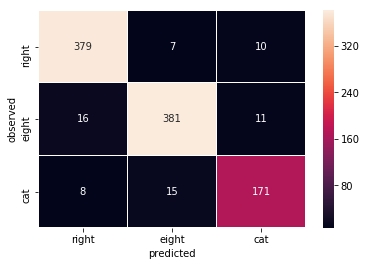

In [25]:
# Compute and plot Confusion matrix 

Ypred = model.predict_classes(Xtest)
cm = confusion_matrix(Y_test, Ypred, labels=[0,1,2])#, labels = words_selected)

ax = seaborn.heatmap(cm, annot=True, fmt='d', 
                     linewidths=.2, 
                     xticklabels=words_selected, 
                     yticklabels=words_selected)

ax.set(xlabel='predicted',ylabel='observed')

# Save the model to disk 

In [26]:
model.save('./model1.hdf5')

# What Next?

You can experiment and expand on the model trained in this notebook. Here are a few areas to explore: 

* increase the number of classes. Try to classify 10+ words 
* add noise to your examples. Create a more robust classifier. 
* try different CNN architectures 
* include an "other" class
* include a "silence" class

# References 

* Warden, P. 2018, "Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition", [arXiv:1804.03209](https://arxiv.org/abs/1804.03209)
* Sainath, T.N., Parada, C. 2015 ["Convolutional Neural Networks for Small-footprint Keyword Spotting"]( https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43969.pdf)

Here's the network architecture for reference. 

![network-architecture](https://user-images.githubusercontent.com/5395649/46776515-cb378280-ccc0-11e8-8dcb-84db4156e981.png)